# Spiral

The goal is to display how the model is learning to draw a spiral, given the input coordintes $x$ and $y$.

A GoMLX coded version of [TensorFlow's Neural Network Playground](https://playground.tensorflow.org/).

## Imports

In [25]:
import (
    "math"
    
    "github.com/gomlx/gomlx/backends"
    . "github.com/gomlx/gomlx/pkg/core/graph"
    "github.com/gomlx/gomlx/pkg/core/shapes"
    "github.com/gomlx/gomlx/pkg/core/tensors"
    "github.com/gomlx/gomlx/pkg/ml/context"
    "github.com/gomlx/gomlx/pkg/ml/datasets"
    "github.com/gomlx/gomlx/pkg/ml/train"
    "github.com/gomlx/gomlx/pkg/ml/train/losses"
    "github.com/gomlx/gomlx/pkg/ml/train/optimizers"
    "github.com/gomlx/gomlx/pkg/core/dtypes"
    "github.com/janpfeifer/gonb/gonbui"
    "github.com/janpfeifer/gonb/cache"

    // Include default backends
    _ "github.com/gomlx/gomlx/backends/default"
)

// Backend used everywhere. Default will use GPU if available, otherwise CPU.
var Backend = backends.MustNew()

// Makes sure there is a valid reference to `graph` package imported inline.
var _ = Add

// Define how we want to fail in case of errors.
func init_must() {
    must.M = func(err error) {
        if err != nil {
            log.Fatal("Error:\n%+v\n", err)
        }
    }
}


## Plotting

We are plotting functions $f(x,y) \text{ where } x, y \in [-1, 1]$. The output of $f(x,y) \in [0, 1]$ represents a degree of grayness 0.0 representing white and 1.0 representing black.

The functions are given GoMLX functions, that take as input one array shaped `[batch_size, 2]` (`batch_size` pairs of $(x, y)$).


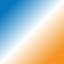

In [26]:
// PlotFn is the graph function accepted by the plot functions: [batch, 2] -> [batch]. The output values should be bewteen -1 and +1.
type PlotFn func (ctx *context.Context, xys *Node) *Node 

// PlotToImg returns the HTML `<img src=...>` of size "size x size", with the plotted function, that can be displayed or composed.
// The context can be nil, if the function doesn't use any variables.
func PlotToImg(ctx *context.Context, fn PlotFn, size int) string {
    if ctx == nil {
        ctx = context.New()
    }
    ctx = ctx.Reuse()  // When plotting, we shouldn't be creating new variables. This way it will fail if function is not yet trained.
    values := context.MustExecOnce(Backend, ctx, func (ctx *context.Context, g *Graph) *Node {
        xys := imgXYsForSize(g, size)
        output := fn(ctx, xys)
        return ClipScalar(output, -1, 1)  // Clip to the values allowed.
    })
    negColor  := color.NRGBA{245, 147, 34, 255}
    zeroColor := color.NRGBA{255, 255, 255, 255}
    posColor  := color.NRGBA{8, 119, 189, 255}
    lerp := func(c1, c2 color.NRGBA, t float32) color.NRGBA {
    	return color.NRGBA{
    		R: uint8(float32(c1.R) + (float32(c2.R)-float32(c1.R))*t),
    		G: uint8(float32(c1.G) + (float32(c2.G)-float32(c1.G))*t),
    		B: uint8(float32(c1.B) + (float32(c2.B)-float32(c1.B))*t),
       		A: uint8(float32(c1.A) + (float32(c2.A)-float32(c1.A))*t),
    	}
    }
    img := image.NewNRGBA(image.Rect(0, 0, size, size))
    tensors.ConstFlatData[float32](values, func (data []float32) {
        for y := range size {
            for x := range size {
                val := data[y * size + x]
            	var c color.NRGBA
            	if val < 0 {
            		c = lerp(posColor, zeroColor, val+1)
            	} else {
            		c = lerp(zeroColor, negColor, val)
            	}
            	img.SetNRGBA(x, y, c)
            }
        }
    })
    
    imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
    return fmt.Sprintf("<img src=%q/>", imgSrc)
}

// imgXYsForSize creates all combination of (x, y) for an image of size (size x size), where $x,y \in [-1, 1]$.
// The output is shaped [batchSize, 2], where batchSize = size * size.
func imgXYsForSize(g *Graph, size int) *Node {
    xs := Iota(g, shapes.Make(dtypes.Float32, size, size), 1) // -> 0, size-1
    xs = AddScalar(DivScalar(xs, float64(size-1)/2.0), -1)  // -> -1.0, 1.0
    ys := Iota(g, shapes.Make(dtypes.Float32, size, size), 0)
    ys = AddScalar(DivScalar(ys, float64(size-1)/2.0), -1)  // -> -1.0, 1.0
    xys := Stack([]*Node{xs, ys}, -1)
    xys = Reshape(xys, size*size, 2)  // Contract width and height axes into a "batch_size" axis.
    return xys
}

// Plot displays an image generated from the given function.
func Plot(ctx *context.Context, fn PlotFn, size int) {
    gonbui.DisplayHTML(PlotToImg(ctx, fn, size))
}

%%
// Small test of a gradient function on the x,y diagonal.
Plot(nil, func (_ *context.Context, xys *Node) *Node {
    value := ReduceAndKeep(xys, ReduceSum, -1)  // x+y -> -2.0 to 2.0
    return DivScalar(value, 1.5)  // Values will be clipped to [-1, +1]
}, 64)


## Spiral Figure

This is the shape we are trying to learn. The `Spiral()` function returns the labels for the given XY input pairs.


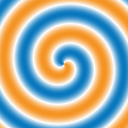

In [41]:
var SpiralAngularSpeed = 10

// Spiral returns values [-1, +1] for the given (X,Y) pairs (xy shaped [batch, 2])
// that represent a spiral.
func Spiral(xy *Node) *Node {
    radius := L2Norm(xy, -1)
    x := Slice(xy, AxisRange(), AxisElem(0))
    y := Slice(xy, AxisRange(), AxisElem(1))
    angle := Atan2(x, y)
    phase := Add(angle, MulScalar(radius, SpiralAngularSpeed))
    return Sin(phase)
}

%%
// Small test of a gradient function on the x,y diagonal.
Plot(nil, func (_ *context.Context, xys *Node) *Node { return Spiral(xys) }, 128)

In [40]:
%%
fmt.Printf("atan2(0,0) = %s\n", MustExecOnce(Backend, func (g *Graph) *Node {
    zero := ScalarZero(g, dtypes.Float32)
    return Atan2(zero, zero)
}))

Set: GOMLX_BACKEND="xla:cpu"
atan2(0,0) = float32(0)


## Training Loop

A small convenient training loop that every second updates the generated image from the model.

In [ ]:
func Model0(ctx *context.Context, []inputs